### Programming Assignment - 2
#### By - Sahil Kochhar
***

Importing neccessary libraries

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from nltk import word_tokenize
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

#### **Problem 1:** Text Classification - Solve the following Multi-class Classification Problem – Cyberbullying Classification
**Description:**
This dataset contains more than 47000 tweets labeled according to the class of cyberbullying:
Age;
Ethnicity;
Gender;
Religion;
Other types of cyberbullying;
Not cyberbullying
The data has been balanced in order to contain ~8000 of each class.

We can combat cyberbullying by creating models to automatically flag potentially harmful tweets as well as break down the patterns of hatred.

**Dataset Link:** https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [ ]:
cyber_dataset = pd.read_csv('cyberbullying_tweets.csv')

In [ ]:
cyber_dataset.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
cyber_dataset.shape

(47692, 2)

In [ ]:
cyber_label_encoder = LabelEncoder()

In [ ]:
cyber_y = cyber_label_encoder.fit_transform(cyber_dataset['cyberbullying_type'])

In [ ]:
np.unique(cyber_dataset['cyberbullying_type'], return_counts=True)

(array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
        'other_cyberbullying', 'religion'], dtype=object),
 array([7992, 7961, 7973, 7945, 7823, 7998], dtype=int64))

In [ ]:
# Preprocessing of test to remove all the puntuations, numbers, single characters and multiple spaces. So that we can easily vectorize the dataset
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


preprocess_text = np.vectorize(preprocess_text)

In [ ]:
X = preprocess_text(np.array(list(cyber_dataset['tweet_text'])))

In [ ]:
english_stopwords = stopwords.words('english')

In [ ]:
tf_idf = TfidfVectorizer(stop_words=english_stopwords)

In [ ]:
X_vec = tf_idf.fit_transform(X)

In [ ]:
glove_embedding_dict = dict()
glove_file_6b_100d = open("E:\datasets\glove\glove.6B.100d.txt", encoding='utf8')
for line in glove_file_6b_100d:
    temp = line.split()
    word = temp[0]
    word_vec = np.asarray(temp[1:], dtype=np.float32)
    glove_embedding_dict[word] = word_vec
glove_file_6b_100d.close()

In [ ]:
glove_my_embeddings = []
zero_vec = 100 * [0]

for key, val in sorted(tf_idf.vocabulary_.items(), key=lambda a: (a[1], a[0])):
    if key in glove_embedding_dict:
        glove_my_embeddings.append(glove_embedding_dict[key])
    else:
        glove_my_embeddings.append(zero_vec)

In [ ]:
glove_my_embeddings = scipy.sparse.csr_matrix(glove_my_embeddings)

In [ ]:
X_embedding = X_vec.dot(glove_my_embeddings)

In [ ]:
X_embedding.shape

(47692, 100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_embedding, cyber_y, random_state=42, test_size=0.3)

In [ ]:
X_train = X_train.todense()
X_test = X_test.todense()

#### Methodology 1:
We have followed these steps for training a fully connected ANN model:
1- Removing the special characters like punctuations, etc. from the dataset.
2- Label encoding the tags that have been given to each tweet
3- Using TF-IDF vectorizer to convert the dataset into vector form
4- Using GLOVE word embedding to create an embedding specific to our case
5- Converting the data in to embedding vector form by multiplying TF-IDF vector with the GLOVE embedding
6- Training the ANN that consists of few fully connected layers using the embedding vector and label encoded values

In [ ]:
ann_model = Sequential([
    Dense(128, activation='tanh', input_shape=(100,)),
    Dropout(0.4),
    Dense(256, activation='tanh'),
    Dropout(0.4),
    Dense(64, activation='tanh'),
    Dropout(0.4),
    Dense(32, activation='tanh'),
    Dense(6, activation='softmax'),
])
ann_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               12928     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 256)               33024     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                16448     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 32)              

In [ ]:
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = ann_model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
1044/1044 [==============================] - 3s 2ms/step - loss: 0.9591 - accuracy: 0.6378 - val_loss: 0.7744 - val_accuracy: 0.7064
Epoch 2/50
1044/1044 [==============================] - 2s 2ms/step - loss: 0.8140 - accuracy: 0.6927 - val_loss: 0.7519 - val_accuracy: 0.7140
Epoch 3/50
1044/1044 [==============================] - 2s 2ms/step - loss: 0.7912 - accuracy: 0.7015 - val_loss: 0.7342 - val_accuracy: 0.7183
Epoch 4/50
1044/1044 [==============================] - 2s 2ms/step - loss: 0.7761 - accuracy: 0.7050 - val_loss: 0.7314 - val_accuracy: 0.7220
Epoch 5/50
1044/1044 [==============================] - 2s 2ms/step - loss: 0.7621 - accuracy: 0.7111 - val_loss: 0.7184 - val_accuracy: 0.7248
Epoch 6/50
1044/1044 [==============================] - 2s 2ms/step - loss: 0.7551 - accuracy: 0.7135 - val_loss: 0.7177 - val_accuracy: 0.7248
Epoch 7/50
1044/1044 [==============================] - 2s 2ms/step - loss: 0.7457 - accuracy: 0.7153 - val_loss: 0.7075 - val_accuracy:

In [ ]:
def plot_training_data(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

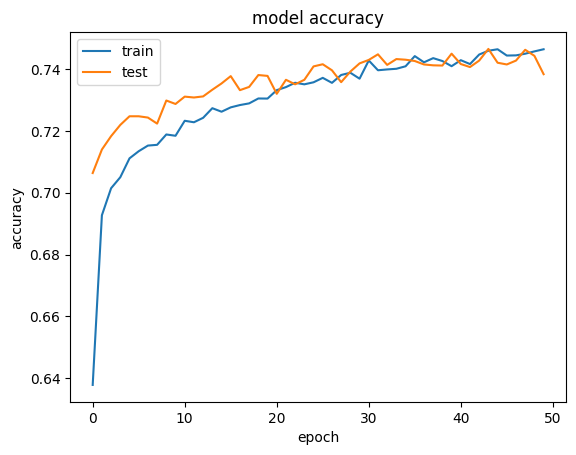

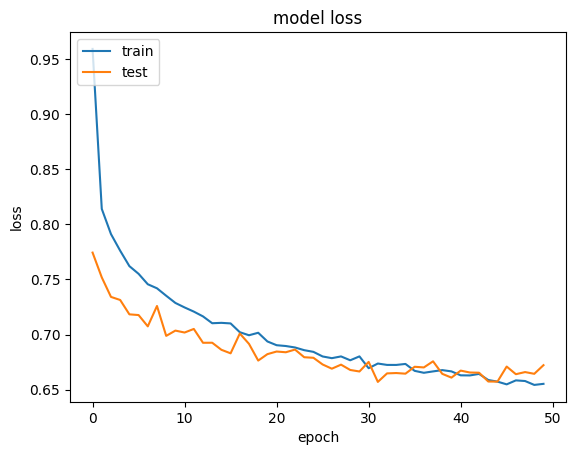

In [ ]:
plot_training_data(history)

In [ ]:
len_of_sen = []
for i in cyber_dataset['tweet_text']:
    len_of_sen.append(len(word_tokenize(i)))

In [ ]:
max(len_of_sen)

1022

In [ ]:
np.quantile(len_of_sen, 0.95)

59.0

In [ ]:
max_len = 80

In [ ]:
tok = Tokenizer(char_level=False, split=' ')

In [ ]:
tok.fit_on_texts(cyber_dataset['tweet_text'])

In [ ]:
sequences = tok.texts_to_sequences(cyber_dataset['tweet_text'])

In [ ]:
seq_matrix = pad_sequences(sequences, max_len)

In [ ]:
vocab_size = len(tok.word_index) + 1

In [ ]:
vocab_size

64678

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))

In [ ]:
for word, index in tok.word_index.items():
    embedding_vector = glove_embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Methodology 2:
For the second method we have used LSTM model for solving the problem at hand, using followin steps:
1- Label encoding the tags that have been given to each tweet
2- Using simple token vectorizer to convert the tweets into vector form
3- Building an embedding-matrix to be used as weights for the embedding layer in the model
4- Making a RNN model using non-training embedding layers with GLOVE embedding as it's weights, followed by a LSTM layer, which is then connected to the fully connect layers.
5- We are training this model using the tokenized vector form of tweets and label encoded tags

In [ ]:
lstm_model = Sequential([
    Input(shape=(max_len,)),
    Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
    LSTM(256),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [ ]:
lstm_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 80, 100)           6467800   
                                                                 
 lstm_13 (LSTM)              (None, 256)               365568    
                                                                 
 dense_49 (Dense)            (None, 64)                16448     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 6)                 390       
                                                                 
Total params: 6,850,206
Trainable params: 382,406
Non-trainable params: 6,467,800
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(seq_matrix, cyber_y, random_state=42, test_size=0.3)

In [ ]:
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
1044/1044 [==============================] - 157s 149ms/step - loss: 0.6269 - accuracy: 0.7548 - val_loss: 0.5016 - val_accuracy: 0.7931
Epoch 2/5
1044/1044 [==============================] - 142s 136ms/step - loss: 0.4492 - accuracy: 0.8159 - val_loss: 0.4430 - val_accuracy: 0.8207
Epoch 3/5
1044/1044 [==============================] - 142s 136ms/step - loss: 0.4095 - accuracy: 0.8288 - val_loss: 0.4377 - val_accuracy: 0.8241
Epoch 4/5
1044/1044 [==============================] - 152s 145ms/step - loss: 0.3796 - accuracy: 0.8424 - val_loss: 0.4273 - val_accuracy: 0.8276
Epoch 5/5
1044/1044 [==============================] - 149s 143ms/step - loss: 0.3512 - accuracy: 0.8515 - val_loss: 0.4268 - val_accuracy: 0.8280


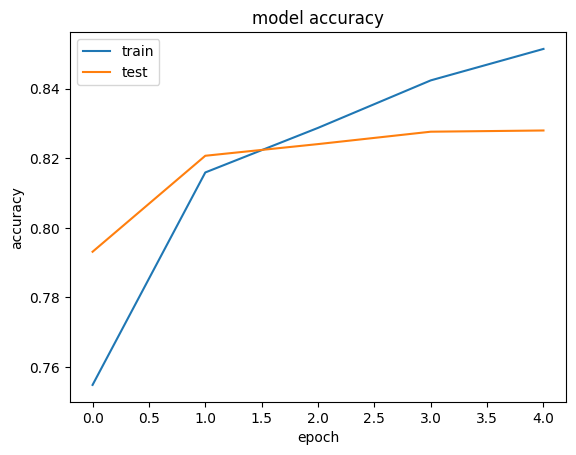

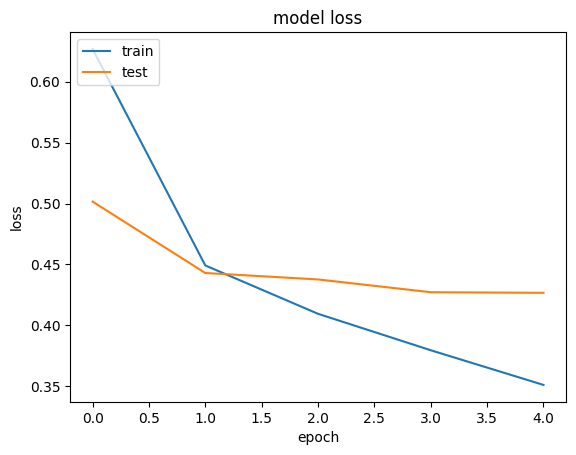

In [ ]:
plot_training_data(history)

#### *Problem 2:* Text Classification - Solve the following Multi-class Classification Problem - Financial Sentiment Analysis
**Description:** The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels.
The main task is to detect the tone of the financial text i.e, positive,negative or neutral.

**Dataset link:** https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [ ]:
financial_dataset = pd.read_csv('fin_data.csv')

In [ ]:
financial_dataset.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
financial_dataset.shape

(5842, 2)

In [ ]:
fin_label_encoder = LabelEncoder()
fin_y = fin_label_encoder.fit_transform(financial_dataset['Sentiment'])

In [ ]:
np.unique(financial_dataset['Sentiment'], return_counts=True)

(array(['negative', 'neutral', 'positive'], dtype=object),
 array([ 860, 3130, 1852], dtype=int64))

In [ ]:
# Preprocessing of test to remove all the puntuations, numbers, single characters and multiple spaces. So that we can easily vectorize the dataset
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

preprocess_text = np.vectorize(preprocess_text)

In [ ]:
X = preprocess_text(np.array(list(financial_dataset['Sentence'])))

In [ ]:
english_stopwords = stopwords.words('english')

In [ ]:
tf_idf = TfidfVectorizer(stop_words=english_stopwords)

In [ ]:
X_vec = tf_idf.fit_transform(X)

In [ ]:
glove_embedding_dict = dict()
glove_file_6b_100d = open("E:\datasets\glove\glove.6B.100d.txt", encoding='utf8')
for line in glove_file_6b_100d:
    temp = line.split()
    word = temp[0]
    word_vec = np.asarray(temp[1:], dtype=np.float32)
    glove_embedding_dict[word] = word_vec
glove_file_6b_100d.close()

In [ ]:
glove_my_embeddings = []
zero_vec = 100*[0]

for key,val in sorted(tf_idf.vocabulary_.items(), key= lambda a: (a[1], a[0])):
    if key in glove_embedding_dict:
        glove_my_embeddings.append(glove_embedding_dict[key])
    else:
        glove_my_embeddings.append(zero_vec)

In [ ]:
glove_my_embeddings = scipy.sparse.csr_matrix(glove_my_embeddings)

In [ ]:
X_embedding = X_vec.dot(glove_my_embeddings)

In [ ]:
X_embedding.shape

(5842, 100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_embedding, fin_y, random_state=42, test_size=0.3)

In [ ]:
X_train = X_train.todense()
X_test = X_test.todense()

#### Methodology 1:
We have followed these steps for training a fully connected ANN model:
1- Removing the special characters like punctuations, etc. from the dataset.
2- Label encoding the tags that have been given to each financial text
3- Using TF-IDF vectorizer to convert the dataset into vector form
4- Using GLOVE word embedding to create an embedding specific to our case
5- Converting the data in to embedding vector form by multiplying TF-IDF vector with the GLOVE embedding
6- Training the ANN that consists of few fully connected layers using the embedding vector and label encoded values

In [ ]:
ann_model = Sequential([
    Dense(128,  activation='tanh', input_shape=(100,)),
    Dropout(0.4),
    Dense(256,  activation='tanh'),
    Dropout(0.4),
    Dense(64,  activation='tanh'),
    Dropout(0.4),
    Dense(32,  activation='tanh'),
    Dense(3,  activation='softmax'),
])
ann_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 128)               12928     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 256)               33024     
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 64)                16448     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 32)              

In [ ]:
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = ann_model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
128/128 [==============================] - 1s 3ms/step - loss: 0.9560 - accuracy: 0.5556 - val_loss: 0.8447 - val_accuracy: 0.6258
Epoch 2/50
128/128 [==============================] - 0s 3ms/step - loss: 0.8664 - accuracy: 0.6038 - val_loss: 0.8032 - val_accuracy: 0.6389
Epoch 3/50
128/128 [==============================] - 0s 2ms/step - loss: 0.8183 - accuracy: 0.6275 - val_loss: 0.7691 - val_accuracy: 0.6549
Epoch 4/50
128/128 [==============================] - 0s 2ms/step - loss: 0.8089 - accuracy: 0.6246 - val_loss: 0.7645 - val_accuracy: 0.6560
Epoch 5/50
128/128 [==============================] - 0s 2ms/step - loss: 0.7837 - accuracy: 0.6415 - val_loss: 0.7434 - val_accuracy: 0.6708
Epoch 6/50
128/128 [==============================] - 0s 2ms/step - loss: 0.7784 - accuracy: 0.6481 - val_loss: 0.7549 - val_accuracy: 0.6594
Epoch 7/50
128/128 [==============================] - 0s 2ms/step - loss: 0.7664 - accuracy: 0.6498 - val_loss: 0.7492 - val_accuracy: 0.6697
Epoch 

In [ ]:
def plot_training_data(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

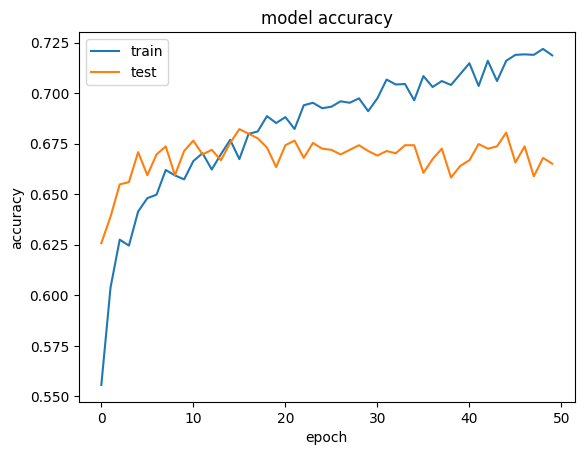

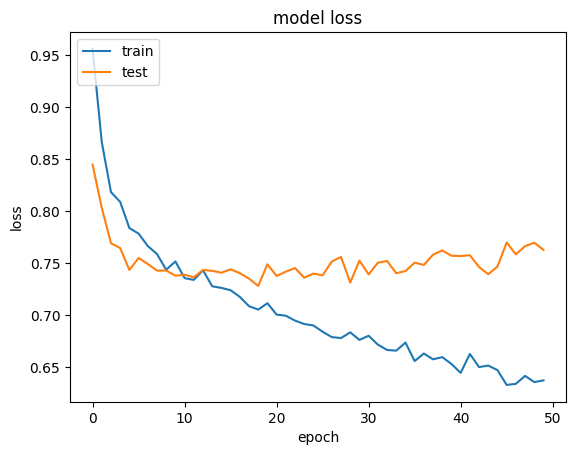

In [ ]:
plot_training_data(history)

In [ ]:
len_of_sen = []
for i in financial_dataset['Sentence']:
    len_of_sen.append(len(word_tokenize(i)))

In [ ]:
max(len_of_sen)

81

In [ ]:
np.quantile(len_of_sen, 0.95)

42.0

In [ ]:
max_len = 45
tok = Tokenizer(char_level=False, split=' ')
tok.fit_on_texts(financial_dataset['Sentence'])

In [ ]:
sequences = tok.texts_to_sequences(financial_dataset['Sentence'])

In [ ]:
seq_matrix = pad_sequences(sequences, max_len)

In [ ]:
vocab_size = len(tok.word_index)+1

In [ ]:
vocab_size

11544

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tok.word_index.items():
    embedding_vector = glove_embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Methodology 2:
For the second method we have used LSTM model for solving the problem at hand, using following steps:
1- Label encoding the tags that have been given to each financial text
2- Using simple token vectorizer to convert the tweets into vector form
3- Building an embedding-matrix to be used as weights for the embedding layer in the model
4- Making a RNN model using non-training embedding layers with GLOVE embedding as it's weights, followed by a LSTM layer, which is then connected to the fully connect layers.
5- We are training this model using the tokenized vector form of financial text and label encoded tags

In [ ]:
lstm_model = Sequential([
    Input(shape=(max_len,)),
    Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
    LSTM(256),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

In [ ]:
lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 45, 100)           1154400   
                                                                 
 lstm_14 (LSTM)              (None, 256)               365568    
                                                                 
 dense_56 (Dense)            (None, 64)                16448     
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,536,611
Trainable params: 382,211
Non-trainable params: 1,154,400
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(seq_matrix, fin_y, random_state=42, test_size=0.3)

In [ ]:
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
128/128 [==============================] - 22s 157ms/step - loss: 0.9013 - accuracy: 0.5891 - val_loss: 0.8250 - val_accuracy: 0.6189
Epoch 2/10
128/128 [==============================] - 19s 152ms/step - loss: 0.8009 - accuracy: 0.6317 - val_loss: 0.7692 - val_accuracy: 0.6526
Epoch 3/10
128/128 [==============================] - 20s 154ms/step - loss: 0.7265 - accuracy: 0.6809 - val_loss: 0.7397 - val_accuracy: 0.6686
Epoch 4/10
128/128 [==============================] - 18s 143ms/step - loss: 0.6632 - accuracy: 0.7070 - val_loss: 0.6927 - val_accuracy: 0.6988
Epoch 5/10
128/128 [==============================] - 17s 136ms/step - loss: 0.6054 - accuracy: 0.7307 - val_loss: 0.6791 - val_accuracy: 0.6914
Epoch 6/10
128/128 [==============================] - 17s 136ms/step - loss: 0.5282 - accuracy: 0.7704 - val_loss: 0.6591 - val_accuracy: 0.7233
Epoch 7/10
128/128 [==============================] - 18s 141ms/step - loss: 0.4658 - accuracy: 0.7907 - val_loss: 0.6463 - val_ac

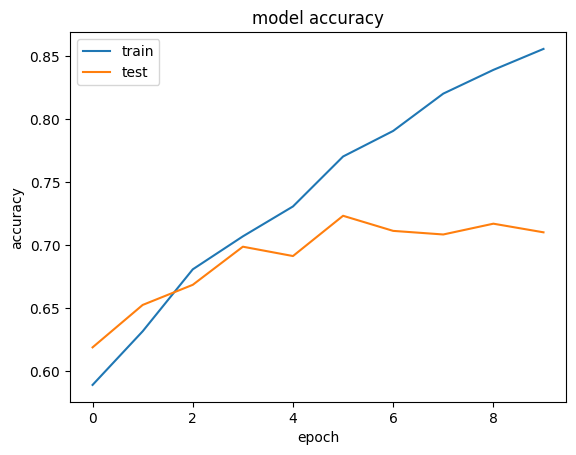

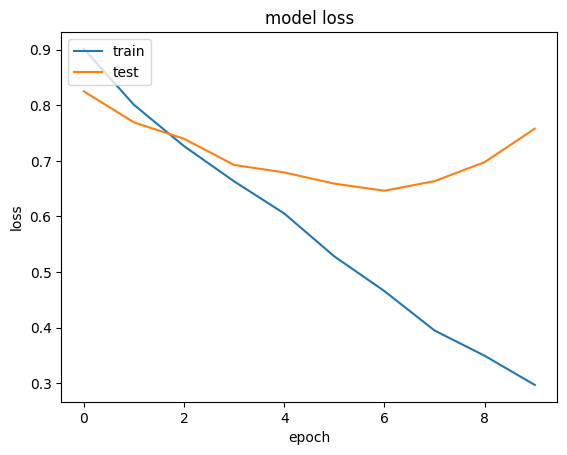

In [ ]:
plot_training_data(history)